In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from pmdarima import auto_arima

from statsmodels.graphics.tsaplots import month_plot, quarter_plot

import warnings
warnings.filterwarnings("ignore")


In [2]:
df = pd.read_csv('TESLA_data_for_30_years.csv', index_col='Date', parse_dates=True)

df.head()


Open      High       Low     Close     Volume  \
Date                                                                           
2010-06-29 00:00:00-04:00  1.266667  1.666667  1.169333  1.592667  281494500   
2010-06-30 00:00:00-04:00  1.719333  2.028000  1.553333  1.588667  257806500   
2010-07-01 00:00:00-04:00  1.666667  1.728000  1.351333  1.464000  123282000   
2010-07-02 00:00:00-04:00  1.533333  1.540000  1.247333  1.280000   77097000   
2010-07-06 00:00:00-04:00  1.333333  1.333333  1.055333  1.074000  103003500   

                           Dividends  Stock Splits  
Date                                                
2010-06-29 00:00:00-04:00        0.0           0.0  
2010-06-30 00:00:00-04:00        0.0           0.0  
2010-07-01 00:00:00-04:00        0.0           0.0  
2010-07-02 00:00:00-04:00        0.0           0.0  
2010-07-06 00:00:00-04:00        0.0           0.0

In [3]:
data = df[['Close']]
data.head()

Close
Date                               
2010-06-29 00:00:00-04:00  1.592667
2010-06-30 00:00:00-04:00  1.588667
2010-07-01 00:00:00-04:00  1.464000
2010-07-02 00:00:00-04:00  1.280000
2010-07-06 00:00:00-04:00  1.074000

In [4]:
data.index = pd.to_datetime(data.index, errors='coerce', utc=True)

data.index = data.index.tz_localize(None)

data.index = data.index.normalize()


In [5]:
data.head()

Close
Date                
2010-06-29  1.592667
2010-06-30  1.588667
2010-07-01  1.464000
2010-07-02  1.280000
2010-07-06  1.074000

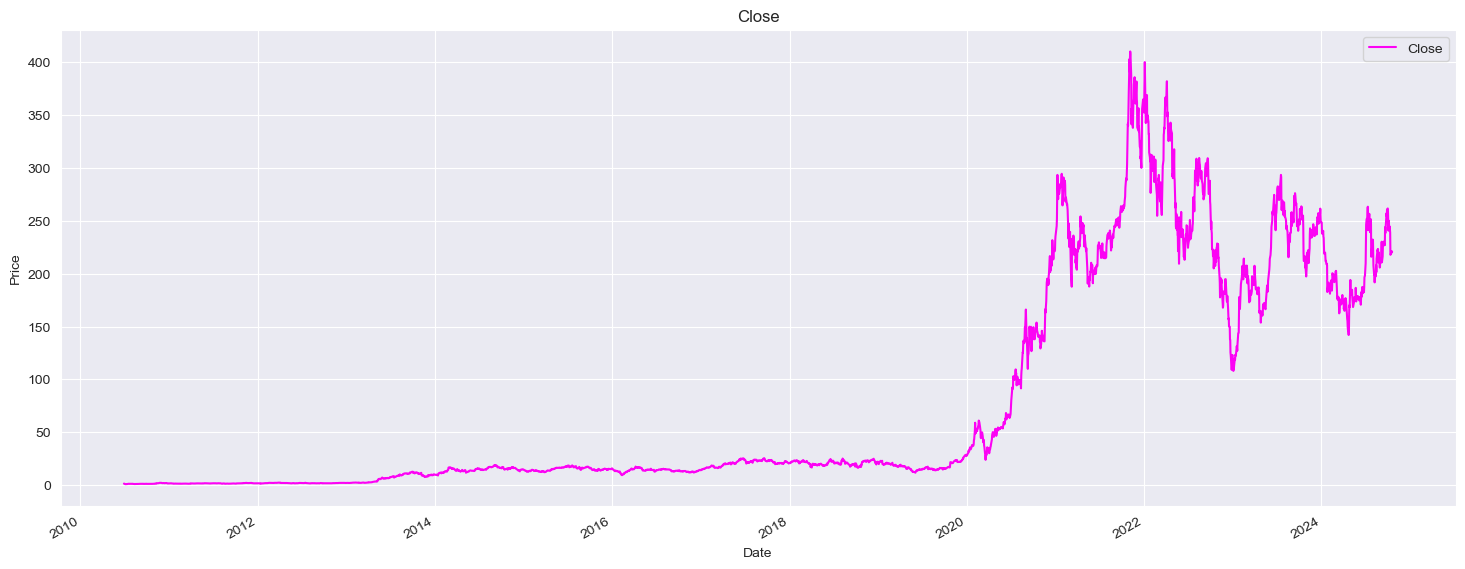

In [6]:
data.plot(figsize=(18,7),legend=True,color='#fc03f4')
plt.ylabel('Price')
plt.title('Close');

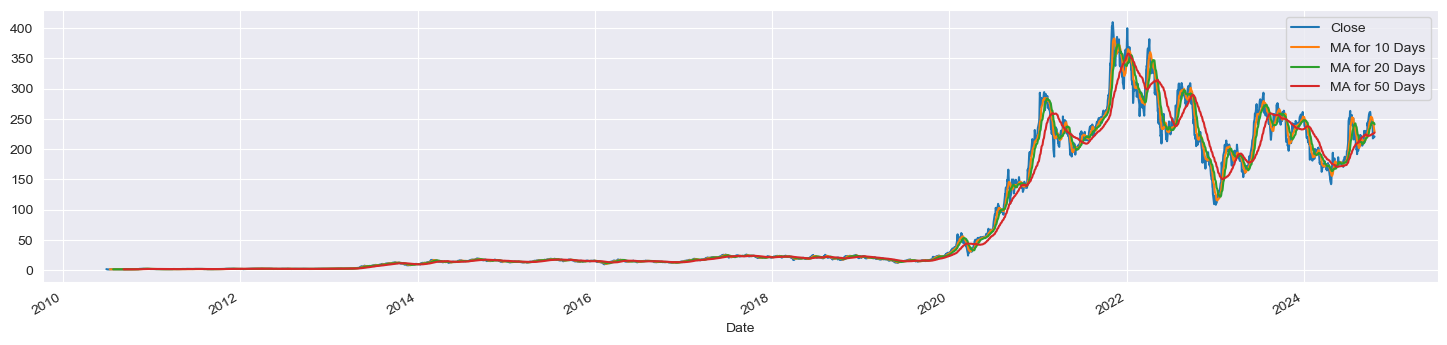

In [7]:
ma_day = [10,20,50]

for ma in ma_day:
    column_names = 'MA for %s Days'%str(ma)
    data[column_names] = data['Close'].rolling(window=ma).mean()

data[['Close','MA for 10 Days','MA for 20 Days','MA for 50 Days']].plot(figsize=(18,4));

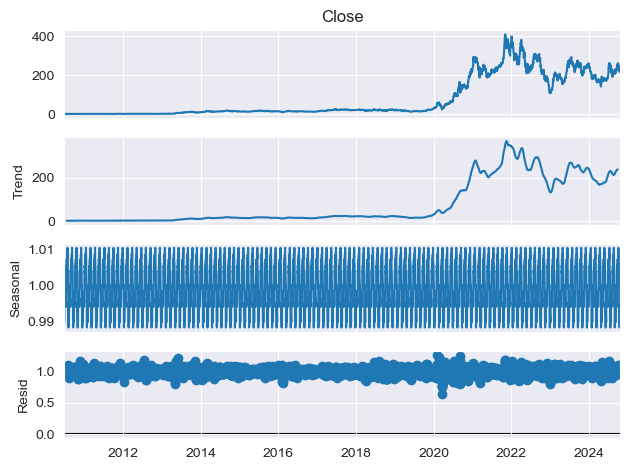

In [8]:
decomposition = seasonal_decompose(data['Close'], model='multiplicative', period=30)
decomposition.plot()
plt.show()

In [9]:
def adf_test(series, title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(), autolag='AIC') 
    
    labels = ['ADF test statistic', 'p-value', '# lags used', '# observations']
    out = pd.Series(result[0:4], index=labels)
    
    for key, val in result[4].items():
        out[f'critical value ({key})'] = val
        
    
    print(out.to_string())    
    
    if result[1] <= 0.05:
        print('Strong evidence against the null hypothesis')
        print('Reject the null hypothesis')
        print('Data has no unit root and is stationary')
        
    else:
        print('Weak evidence against the null hypothesis')
        print('Fail to reject the null hypothesis')
        print('Data has a unit root and is non-stationary')

In [10]:
adf_test(data['Close'])

Augmented Dickey-Fuller Test: 
ADF test statistic        -1.142537
p-value                    0.697814
# lags used               29.000000
# observations          3572.000000
critical value (1%)       -3.432182
critical value (5%)       -2.862349
critical value (10%)      -2.567201
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


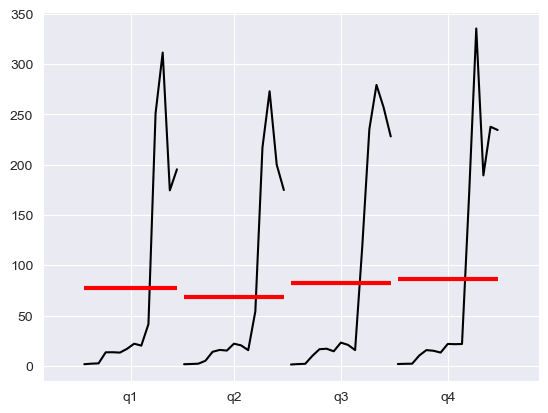

In [11]:
dfq = data['Close'].resample(rule='Q').mean()
quarter_plot(dfq);

## ARIMA

In [12]:
stepwise_fit = auto_arima(data['Close'], start_p=1, max_p=6, 
                          start_q=1, max_q=6, start_d=0, max_d=2, 
                          trace=True)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=21596.589, Time=1.90 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=21599.320, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=21597.173, Time=0.45 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=21597.301, Time=0.48 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=21597.886, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=21598.546, Time=2.00 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=21598.544, Time=1.67 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=21598.419, Time=0.80 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=21598.321, Time=0.47 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=21600.556, Time=2.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=21595.181, Time=0.52 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=21595.907, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=21595.779, Time=0.20 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=21597.134, Time=1.59 sec
 ARIMA(1,1,2)(0,0,0

In [13]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3602
Model:               SARIMAX(1, 1, 1)   Log Likelihood              -10794.590
Date:                Wed, 23 Oct 2024   AIC                          21595.181
Time:                        16:11:17   BIC                          21613.748
Sample:                             0   HQIC                         21601.797
                               - 3602                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6007      0.125     -4.795      0.000      -0.846      -0.355
ma.L1          0.5662      0.130      4.366      0.000       0.312       0.820
sigma2        23.5108      0.182    129.231      0.000      23.154      23.867
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             41984.50
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):            1025.16   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [14]:
len(data)

3602

In [15]:
train, test = data.iloc[:3500], data.iloc[3500:]

In [16]:
from statsmodels.tsa.arima.model import ARIMA

train_values = train['Close'].values
test_values = test['Close'].values

history = [x for x in train_values]
predictions = list()

for t in range(len(test_values)):
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_values[t]
    history.append(obs)
    print("predicted = %f, expected = %f" % (yhat, obs))

predicted = 173.710188, expected = 179.240005
predicted = 179.098214, expected = 176.750000
predicted = 176.898022, expected = 176.190002
predicted = 176.126551, expected = 178.789993
predicted = 178.749967, expected = 178.080002
predicted = 178.121764, expected = 176.289993
predicted = 176.318561, expected = 174.770004
predicted = 174.797922, expected = 175.000000
predicted = 174.978444, expected = 177.940002
predicted = 177.867829, expected = 177.479996
predicted = 177.531880, expected = 173.789993
predicted = 173.867007, expected = 170.660004
predicted = 170.707357, expected = 177.289993
predicted = 177.076075, expected = 182.470001
predicted = 182.438419, expected = 178.009995
predicted = 178.152699, expected = 187.440002
predicted = 187.092733, expected = 184.860001
predicted = 185.121090, expected = 181.570007
predicted = 181.526815, expected = 183.009995
predicted = 182.991410, expected = 182.580002
predicted = 182.602189, expected = 187.350006
predicted = 187.201369, expected =

In [17]:
error = np.sqrt(mean_squared_error(test_values, predictions))
print('Testing RMSE: %.3f' % error)

Testing RMSE: 8.188


In [18]:
test['Close'].mean()

217.92862776214002

In [19]:
test['predictions'] = predictions
test

Close  MA for 10 Days  MA for 20 Days  MA for 50 Days  \
Date                                                                     
2024-05-24  179.240005      177.037003      178.331001      171.448001   
2024-05-28  176.750000      177.523003      177.466001      171.711601   
2024-05-29  176.190002      177.387003      177.111501      171.759401   
2024-05-30  178.789993      177.867001      177.051501      171.908800   
2024-05-31  178.080002      178.191002      176.955001      171.957200   
...                ...             ...             ...             ...   
2024-10-14  219.160004      239.989001      243.736500      225.536001   
2024-10-15  219.570007      236.144003      243.321500      225.949801   
2024-10-16  221.330002      233.375003      243.028001      226.363601   
2024-10-17  220.889999      231.398003      241.876501      226.946201   
2024-10-18  220.699997      228.460002      240.999001      227.383401   

            predictions  
Date                     
2024-05-24   173.710188  
2024-05-28   179.098214  
2024-05-29   176.898022  
2024-05-30   176.126551  
2024-05-31   178.749967  
...                 ...  
2024-10-14   218.594000  
2024-10-15   218.662615  
2024-10-16   219.835955  
2024-10-17   221.117712  
2024-10-18   221.025521  

[102 rows x 5 columns]

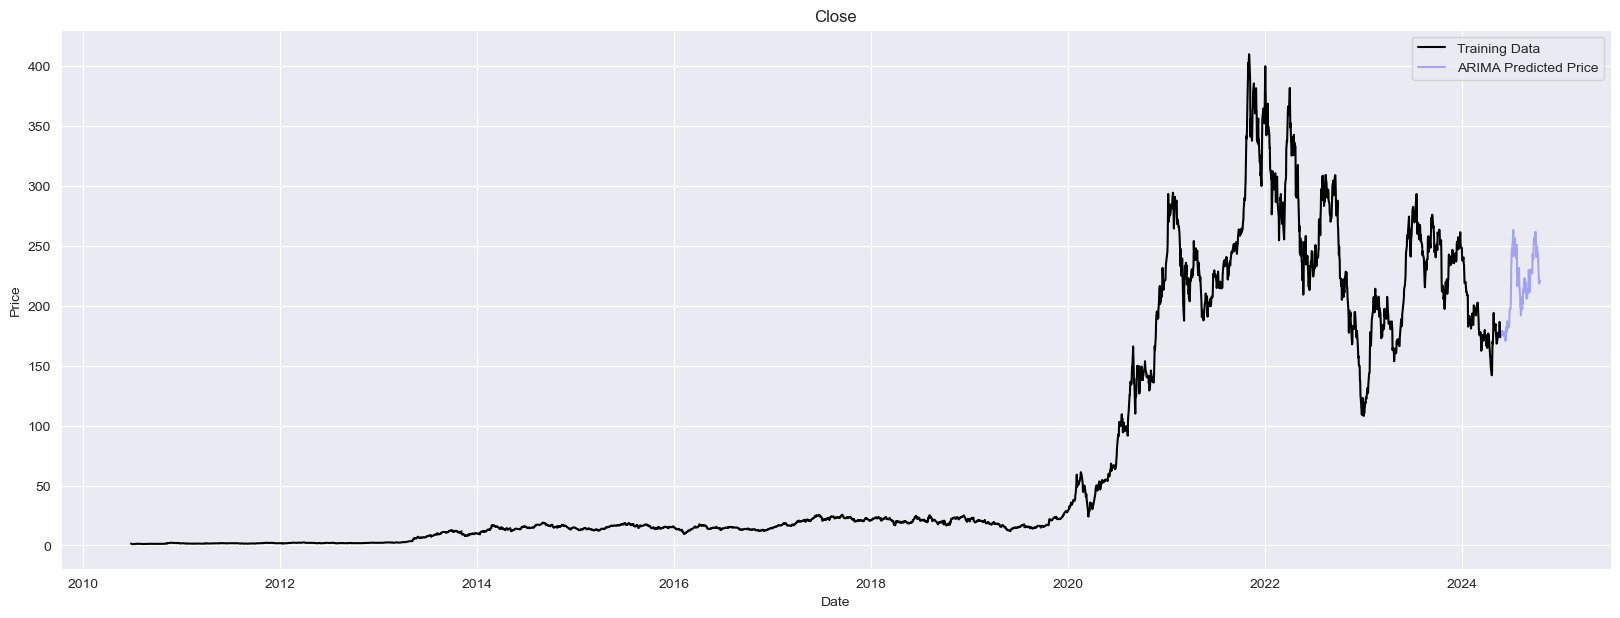

In [20]:
plt.figure(figsize=(20,7))
plt.title('Close')
plt.xlabel('Date')
plt.ylabel('Price')
plt.plot(train['Close'], 'black', label='Training Data')
plt.plot(test['predictions'], 'blue', alpha = 0.3, label = 'ARIMA Predicted Price')
plt.legend();

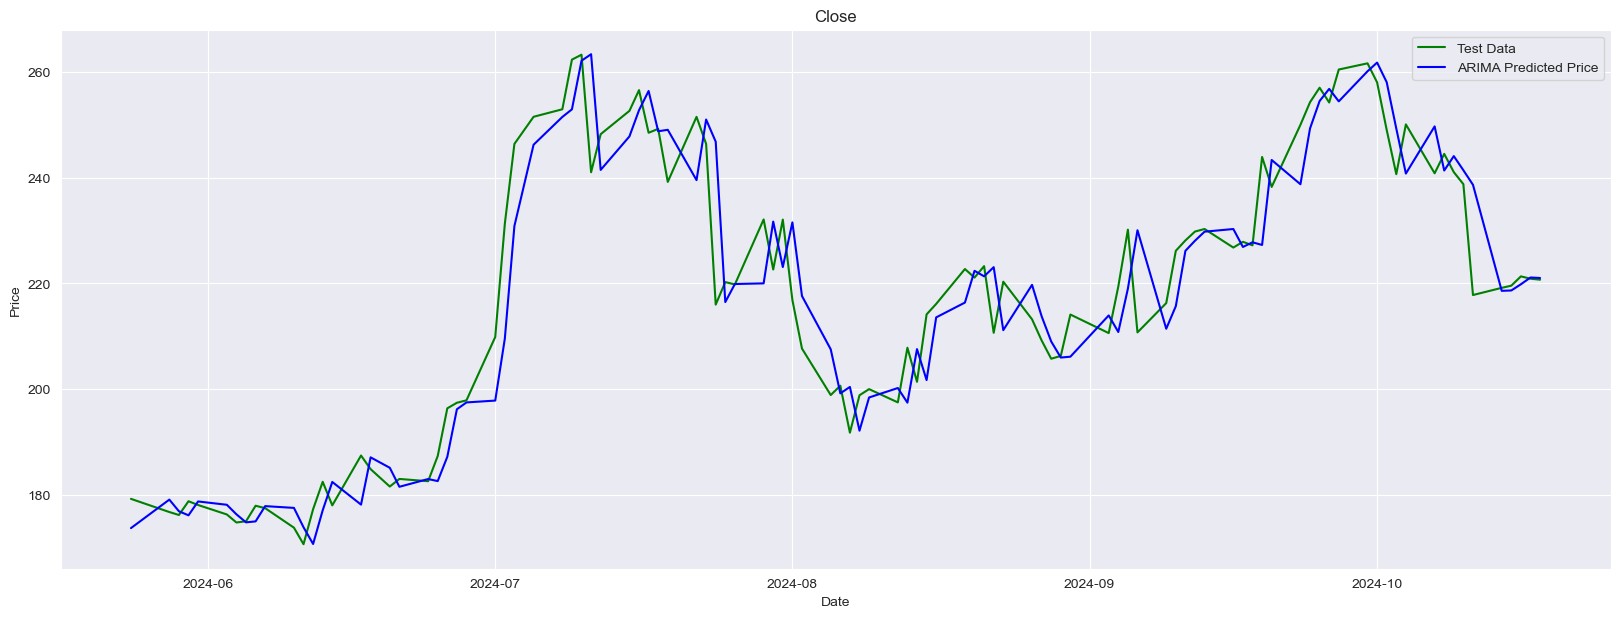

In [21]:
plt.figure(figsize=(20,7))
plt.title('Close')
plt.xlabel('Date')
plt.ylabel('Price')
plt.plot(test['Close'], 'green', label = 'Test Data')
plt.plot(test['predictions'], 'blue', label = 'ARIMA Predicted Price')
plt.legend();

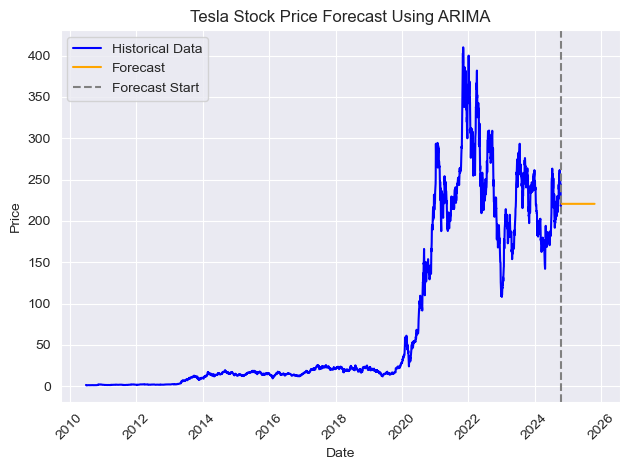

In [22]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

df_arima = data[['Close']].copy()

df_arima.index = pd.to_datetime(df_arima.index).tz_localize(None)

model = ARIMA(df_arima['Close'], order=(1, 1, 1))
model_fit = model.fit()

forecast_steps = 365  
forecast = model_fit.predict(start=len(df_arima), end=len(df_arima) + forecast_steps - 1, typ='levels').rename('ARIMA Forecast')

forecast_index = pd.date_range(start=df_arima.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D')

title = 'Tesla Stock Price Forecast Using ARIMA'
xlabel = 'Date'
ylabel = 'Price'

plt.plot(df_arima.index, df_arima['Close'], label='Historical Data', color='blue')

plt.plot(forecast_index, forecast, label='Forecast', color='orange')

plt.axvline(x=df_arima.index[-1], color='gray', linestyle='--', label='Forecast Start')

plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


## trying with diffrent p values

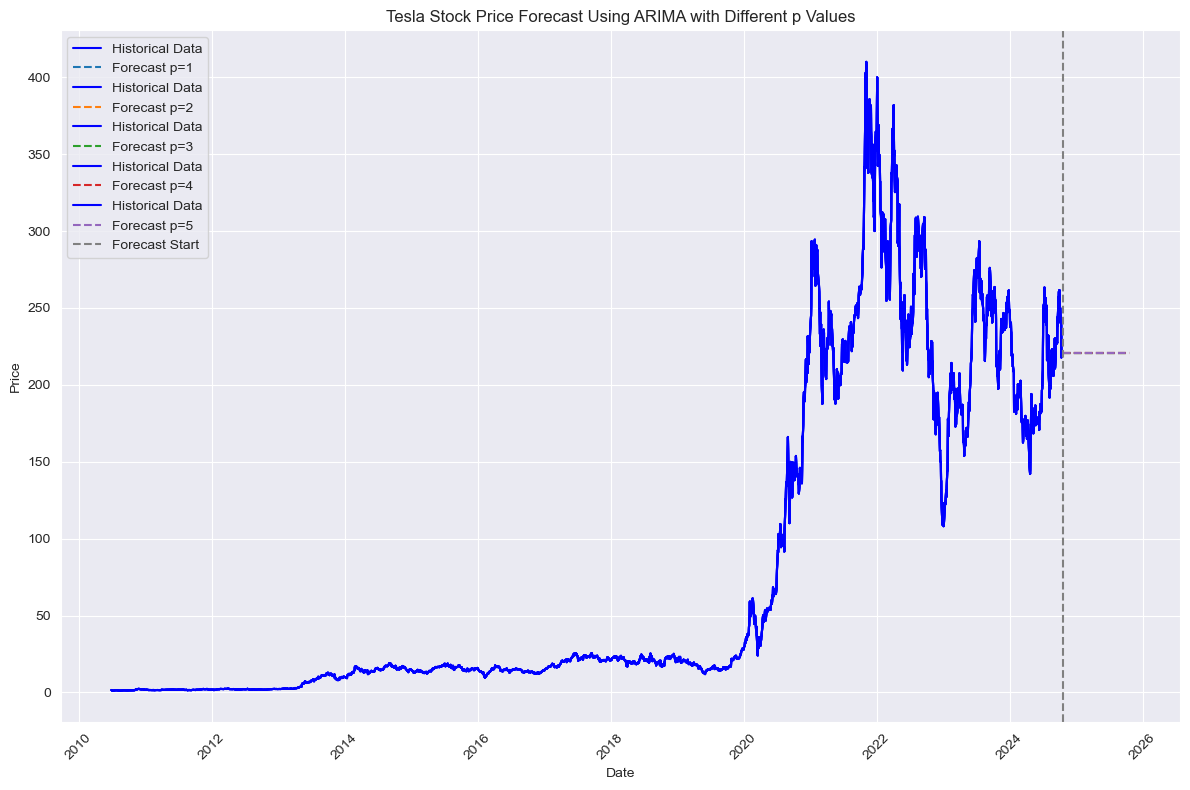

In [23]:

df_arima = data[['Close']].copy()
df_arima.index = pd.to_datetime(df_arima.index).tz_localize(None)

forecast_steps = 365  
p_values = range(1, 6)  

plt.figure(figsize=(12, 8))

for p in p_values:
    model = ARIMA(df_arima['Close'], order=(p, 1, 1))
    model_fit = model.fit()

    forecast = model_fit.predict(start=len(df_arima), end=len(df_arima) + forecast_steps - 1, typ='levels').rename(f'ARIMA Forecast p={p}')

    forecast_index = pd.date_range(start=df_arima.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D')

    plt.plot(df_arima.index, df_arima['Close'], label='Historical Data', color='blue')
    plt.plot(forecast_index, forecast, label=f'Forecast p={p}', linestyle='--')

plt.axvline(x=df_arima.index[-1], color='gray', linestyle='--', label='Forecast Start')
plt.title('Tesla Stock Price Forecast Using ARIMA with Different p Values')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


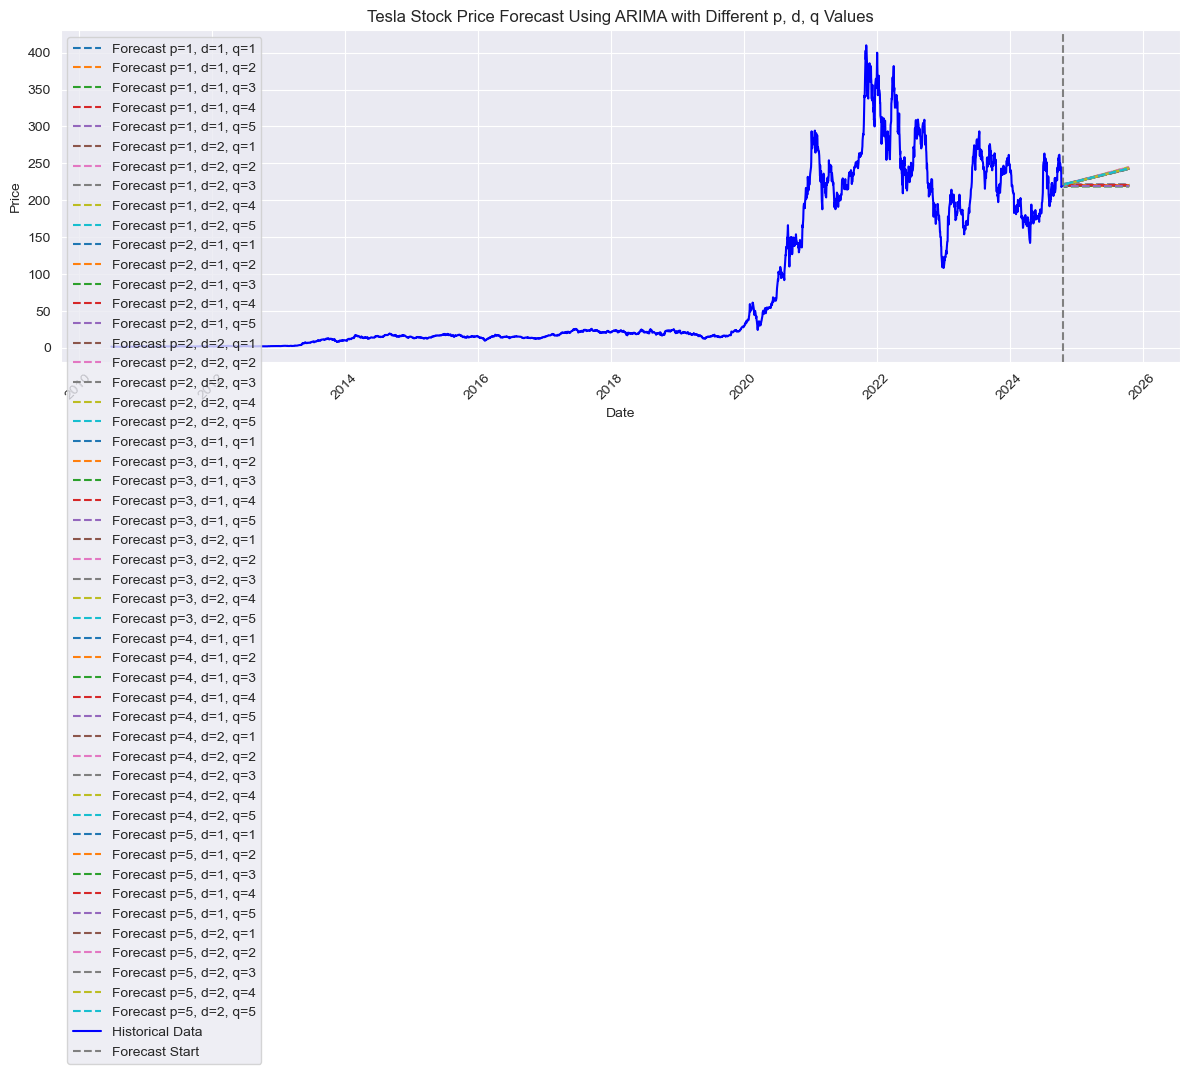

In [24]:


df_arima = data[['Close']].copy()
df_arima.index = pd.to_datetime(df_arima.index).tz_localize(None)

forecast_steps = 365  
p_values = range(1, 6)  
d_values = range(1, 3)  
q_values = range(1, 6)  

plt.figure(figsize=(12, 8))

for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                model = ARIMA(df_arima['Close'], order=(p, d, q))
                model_fit = model.fit()

                forecast = model_fit.predict(start=len(df_arima), end=len(df_arima) + forecast_steps - 1, typ='levels').rename(f'ARIMA Forecast p={p}, d={d}, q={q}')

                forecast_index = pd.date_range(start=df_arima.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D')

                plt.plot(forecast_index, forecast, label=f'Forecast p={p}, d={d}, q={q}', linestyle='--')

            except Exception as e:
                print(f"Failed to fit ARIMA model with p={p}, d={d}, q={q}. Error: {e}")

plt.plot(df_arima.index, df_arima['Close'], label='Historical Data', color='blue')

plt.axvline(x=df_arima.index[-1], color='gray', linestyle='--', label='Forecast Start')
plt.title('Tesla Stock Price Forecast Using ARIMA with Different p, d, q Values')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


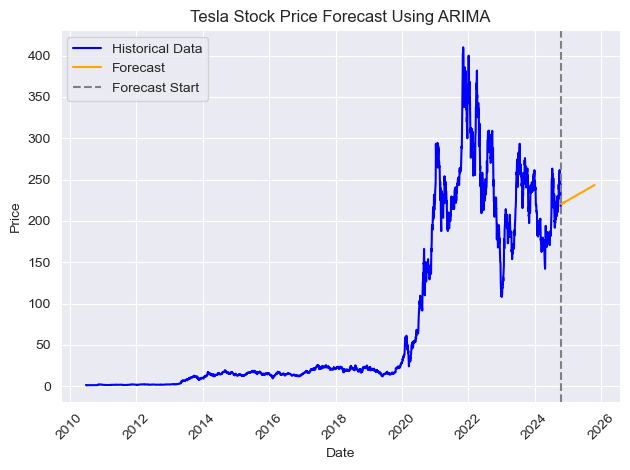

In [25]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

df_arima = data[['Close']].copy()

df_arima.index = pd.to_datetime(df_arima.index).tz_localize(None)

model = ARIMA(df_arima['Close'], order=(4, 2, 4))
model_fit = model.fit()

forecast_steps = 365  
forecast = model_fit.predict(start=len(df_arima), end=len(df_arima) + forecast_steps - 1, typ='levels').rename('ARIMA Forecast')

forecast_index = pd.date_range(start=df_arima.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D')

title = 'Tesla Stock Price Forecast Using ARIMA'
xlabel = 'Date'
ylabel = 'Price'

plt.plot(df_arima.index, df_arima['Close'], label='Historical Data', color='blue')

plt.plot(forecast_index, forecast, label='Forecast', color='orange')

plt.axvline(x=df_arima.index[-1], color='gray', linestyle='--', label='Forecast Start')

plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


### Trying from 2020, to get a better graph

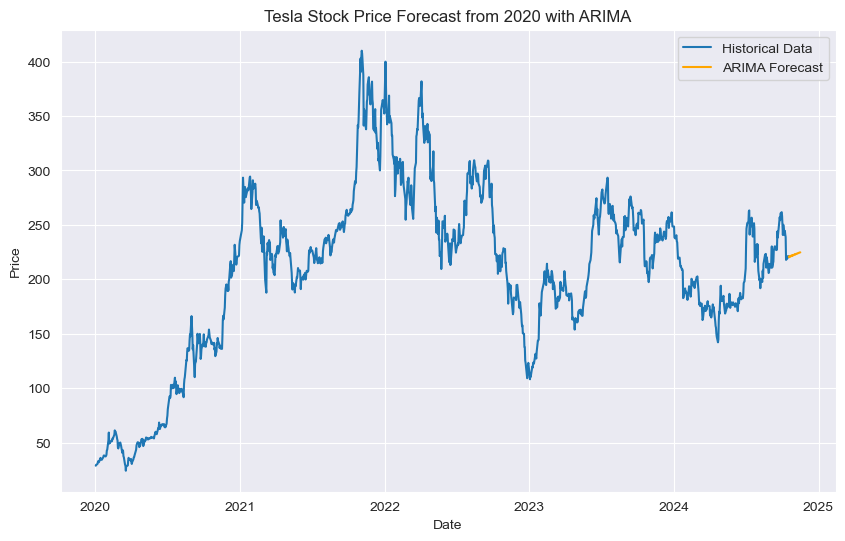

In [26]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

df_arima = data[['Close']].copy()
df_arima = df_arima[df_arima.index >= '2020-01-01']

df_arima.index = pd.to_datetime(df_arima.index).tz_localize(None)

model = ARIMA(df_arima['Close'], order=(4, 2, 4))  
model_fit = model.fit()

future = pd.date_range(start=df_arima.index.max(), periods=30, freq='D')

forecast = model_fit.forecast(steps=30)

forecast_df = pd.DataFrame({'Date': future, 'Forecast': forecast})

plt.figure(figsize=(10,6))
plt.plot(df_arima.index, df_arima['Close'], label='Historical Data')
plt.plot(forecast_df['Date'], forecast_df['Forecast'], label='ARIMA Forecast', color='orange')

plt.title("Tesla Stock Price Forecast from 2020 with ARIMA")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.show()


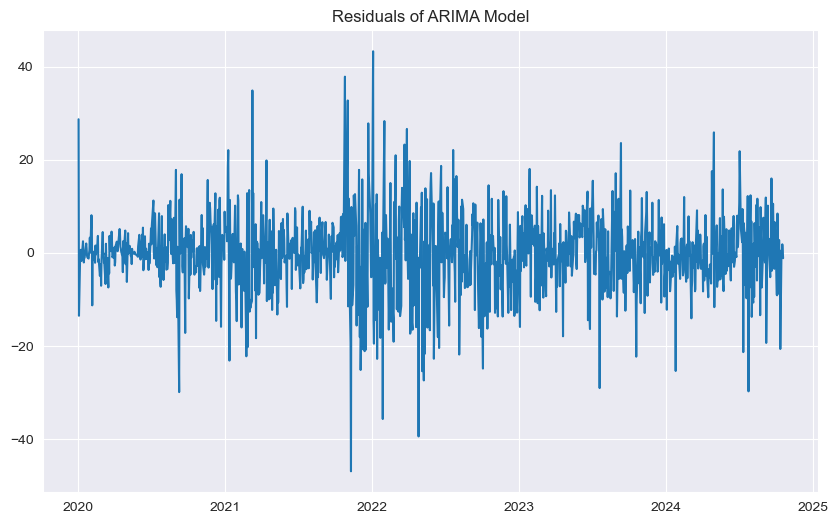

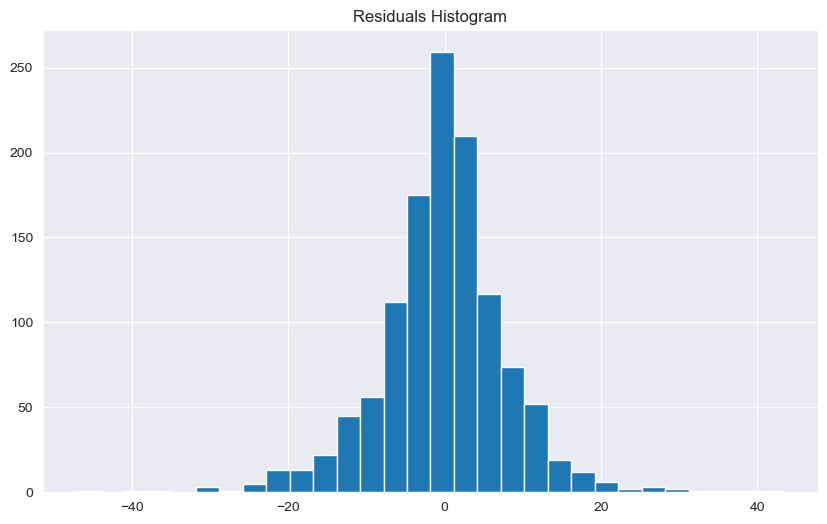

In [27]:
residuals = model_fit.resid
plt.figure(figsize=(10,6))
plt.plot(residuals)
plt.title("Residuals of ARIMA Model")
plt.show()

# Histogram of residuals
plt.figure(figsize=(10,6))
plt.hist(residuals, bins=30)
plt.title("Residuals Histogram")
plt.show()


## The auto ARIMA test did not yield good results. However, after adjusting the parameters, we observed noticeable changes in the graph

### SARIMAX

stepwise_fit = auto_arima(data['Close'], start_p=0, max_p=4, 
                          start_q=0, max_q=4, seasonal=True, m=12, trace=True)
                          
## takes a lot of time for a run, score was - order=(2,1,2), seasonal_order=(2,0,0,12)


In [28]:
stepwise_fit = SARIMAX(df_arima['Close'], order=(2, 1, 2), seasonal_order=(2, 0, 0, 12))
stepwise_fit = stepwise_fit.fit()

In [29]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               Close   No. Observations:                 1208
Model:             SARIMAX(2, 1, 2)x(2, 0, [], 12)   Log Likelihood               -4267.562
Date:                             Wed, 23 Oct 2024   AIC                           8549.123
Time:                                     16:16:00   BIC                           8584.795
Sample:                                          0   HQIC                          8562.557
                                            - 1208                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2698      0.361      0.747      0.455      -0.438       0.978
ar.L2          0.4689      0.361      1.299      0.194      -0.239       1.176
ma.L1         -0.2943      0.369     -0.797      0.426      -1.018       0.430
ma.L2         -0.4194      0.375     -1.119      0.263      -1.154       0.315
ar.S.L12       0.0076      0.029      0.261      0.794      -0.050       0.065
ar.S.L24       0.1061      0.023      4.569      0.000       0.061       0.152
sigma2        68.9402      1.680     41.035      0.000      65.647      72.233
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):               738.02
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               1.22   Skew:                            -0.21
Prob(H) (two-sided):                  0.05   Kurtosis:                         6.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [30]:
train_1, test_1 = data.iloc[:3560], data.iloc[3560:]

In [31]:
train_values_1 = train_1['Close'].values
test_values_1 = test_1['Close'].values

history = [x for x in train_values_1]
predictions_1 = list()

for t in range(len(test_values_1)):
    model = SARIMAX(history, order=(2,1,2), seasonal_order=(2,0,0,12))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions_1.append(yhat)
    obs = test_values_1[t]
    history.append(obs)
    print("predicted = %f, expected = %f" % (yhat, obs))

predicted = 221.515531, expected = 223.270004
predicted = 222.320730, expected = 210.660004
predicted = 212.292541, expected = 220.320007
predicted = 219.330882, expected = 213.210007
predicted = 210.785231, expected = 209.210007
predicted = 209.256475, expected = 205.750000
predicted = 206.024187, expected = 206.279999
predicted = 207.156458, expected = 214.110001
predicted = 213.163736, expected = 210.600006
predicted = 211.800756, expected = 219.410004
predicted = 217.628017, expected = 230.169998
predicted = 229.336152, expected = 210.729996
predicted = 210.748276, expected = 216.270004
predicted = 215.580053, expected = 226.169998
predicted = 225.567833, expected = 228.130005
predicted = 228.960031, expected = 229.809998
predicted = 230.133626, expected = 230.289993
predicted = 230.187284, expected = 226.779999
predicted = 228.097617, expected = 227.869995
predicted = 227.303991, expected = 227.199997
predicted = 228.576954, expected = 243.919998
predicted = 243.905590, expected =

In [32]:
error_1 = np.sqrt(mean_squared_error(test_values_1, predictions_1))
print('Testing RMSE: %.3f' % error_1)

Testing RMSE: 7.330


In [33]:
test_1['Close'].mean()

230.6759530930292

In [34]:
test_1['predictions'] = predictions_1
test_1

Close  MA for 10 Days  MA for 20 Days  MA for 50 Days  \
Date                                                                     
2024-08-21  223.270004      210.289001      212.277001      216.385600   
2024-08-22  210.660004      211.471002      211.797501      217.185600   
2024-08-23  220.320007      213.503003      211.823502      218.046201   
2024-08-26  213.210007      215.075003      210.879002      218.661001   
2024-08-27  209.210007      215.213004      210.208502      219.285001   
2024-08-28  205.750000      215.650003      208.892502      219.651201   
2024-08-29  206.279999      214.864003      208.363502      220.079601   
2024-08-30  214.110001      214.663004      208.685502      220.730401   
2024-09-03  210.600006      213.451004      209.271502      221.282201   
2024-09-04  219.410004      213.282004      210.210002      222.018801   
2024-09-05  230.169998      213.972003      212.130502      222.875201   
2024-09-06  210.729996      213.979002      212.725002      223.162401   
2024-09-09  216.270004      213.574002      213.538503      223.539401   
2024-09-10  226.169998      214.870001      214.972502      224.105201   
2024-09-11  228.130005      216.762001      215.987502      224.470601   
2024-09-12  229.809998      219.168001      217.409002      224.441601   
2024-09-13  230.289993      221.569000      218.216502      224.119601   
2024-09-16  226.779999      222.836000      218.749502      223.624801   
2024-09-17  227.869995      224.562999      219.007001      223.123401   
2024-09-18  227.199997      225.341998      219.312001      222.420801   
2024-09-19  243.919998      226.716998      220.344501      222.034001   
2024-09-20  238.250000      229.468999      221.724001      221.978401   
2024-09-23  250.000000      232.841998      223.208000      222.013801   
2024-09-24  254.270004      235.651999      225.261000      222.046401   
2024-09-25  257.019989      238.540997      227.651499      222.055601   
2024-09-26  254.220001      240.981998      230.074999      222.170001   
2024-09-27  260.459991      243.998997      232.783999      222.394601   
2024-09-30  261.630005      247.483998      235.159999      222.843201   
2024-10-01  258.019989      250.498997      237.530998      222.973401   
2024-10-02  249.020004      252.680998      239.011498      223.026201   
2024-10-03  240.660004      252.354999      239.535999      223.519601   
2024-10-04  250.080002      253.537999      241.503499      224.116201   
2024-10-07  240.830002      252.620999      242.731499      224.536801   
2024-10-08  244.500000      251.643999      243.647999      224.784800   
2024-10-09  241.050003      250.047000      244.293999      225.153401   
2024-10-10  238.770004      248.502000      244.741999      225.287401   
2024-10-11  217.800003      244.236002      244.117500      225.306201   
2024-10-14  219.160004      239.989001      243.736500      225.536001   
2024-10-15  219.570007      236.144003      243.321500      225.949801   
2024-10-16  221.330002      233.375003      243.028001      226.363601   
2024-10-17  220.889999      231.398003      241.876501      226.946201   
2024-10-18  220.699997      228.460002      240.999001      227.383401   

            predictions  
Date                     
2024-08-21   221.515531  
2024-08-22   222.320730  
2024-08-23   212.292541  
2024-08-26   219.330882  
2024-08-27   210.785231  
2024-08-28   209.256475  
2024-08-29   206.024187  
2024-08-30   207.156458  
2024-09-03   213.163736  
2024-09-04   211.800756  
2024-09-05   217.628017  
2024-09-06   229.336152  
2024-09-09   210.748276  
2024-09-10   215.580053  
2024-09-11   225.567833  
2024-09-12   228.960031  
2024-09-13   230.133626  
2024-09-16   230.187284  
2024-09-17   228.097617  
2024-09-18   227.303991  
2024-09-19   228.576954  
2024-09-20   243.905590  
2024-09-23   239.844054  
2024-09-24   249.179128  
2024-09-25   255.165128  
2024-09-26   255.985291  
2024-09-27   255.727715  
2024-0

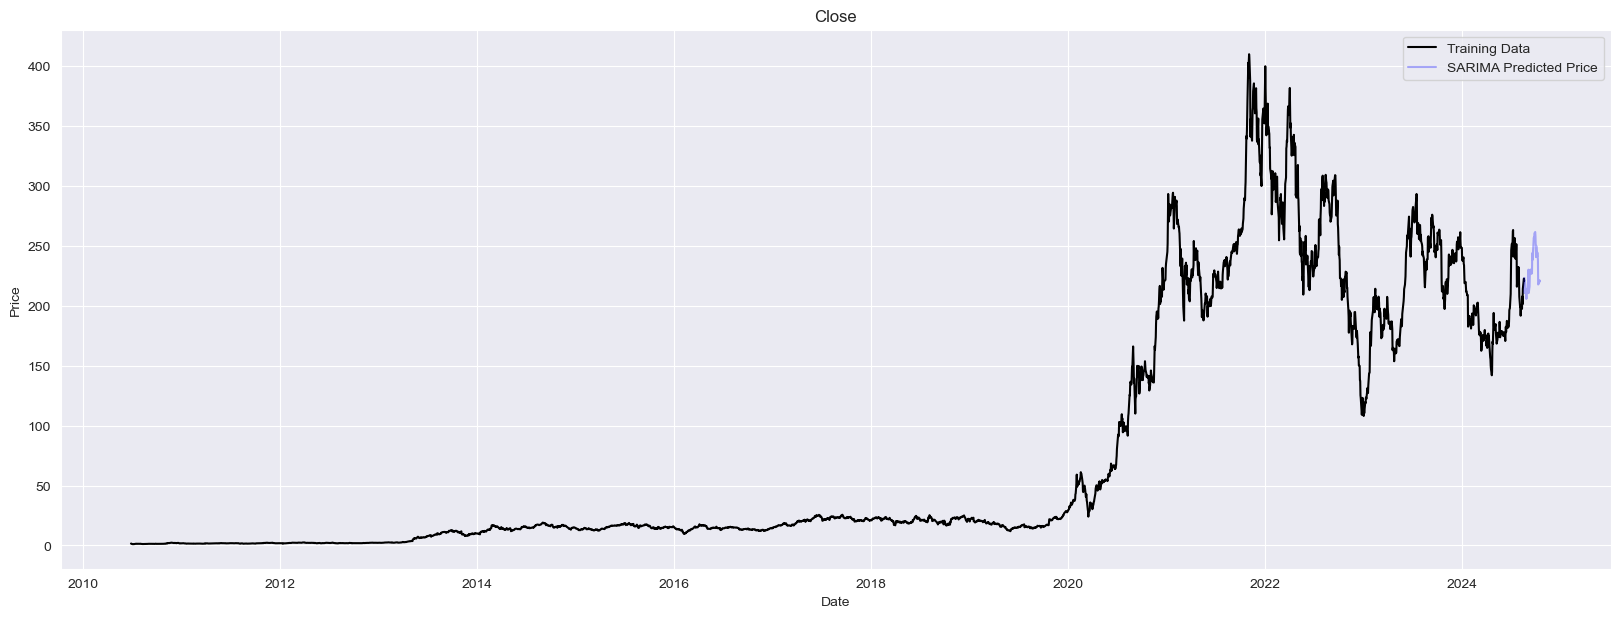

In [35]:
plt.figure(figsize=(20,7))
plt.title('Close')
plt.xlabel('Date')
plt.ylabel('Price')
plt.plot(train_1['Close'], 'black', label='Training Data')
plt.plot(test_1['Close'], 'blue', alpha = 0.3, label = 'SARIMA Predicted Price')
plt.legend();

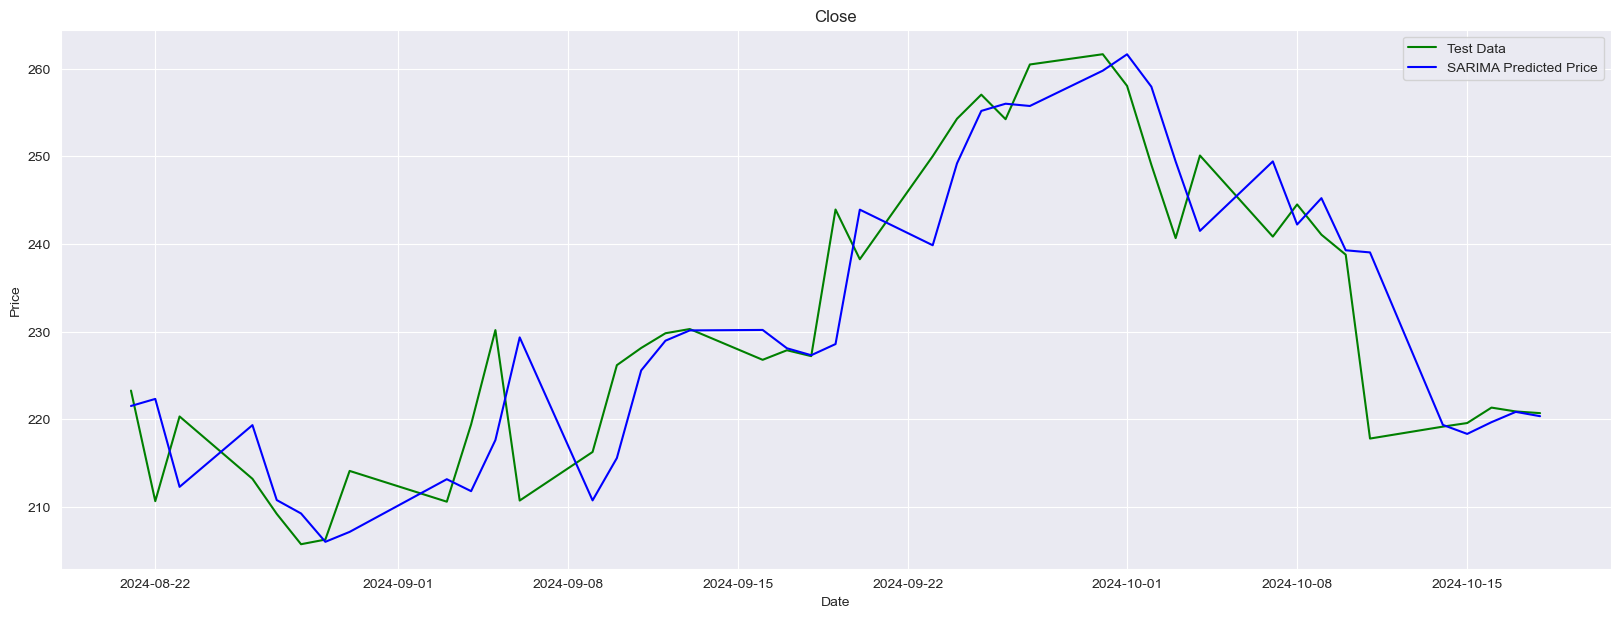

In [36]:
plt.figure(figsize=(20,7))
plt.title('Close')
plt.xlabel('Date')
plt.ylabel('Price')

plt.plot(test_1.index, test_1['Close'], 'green', label = 'Test Data')

plt.plot(test_1.index, predictions_1, 'blue', label = 'SARIMA Predicted Price')

plt.legend()
plt.show()


In [37]:
model = SARIMAX(data['Close'], order=(2,1,2), seasonal_order=(2,0,0,12))
results = model.fit()

fcast = results.predict(len(data), len(data)+102, typ='levels').rename('SARIMA Forecast')

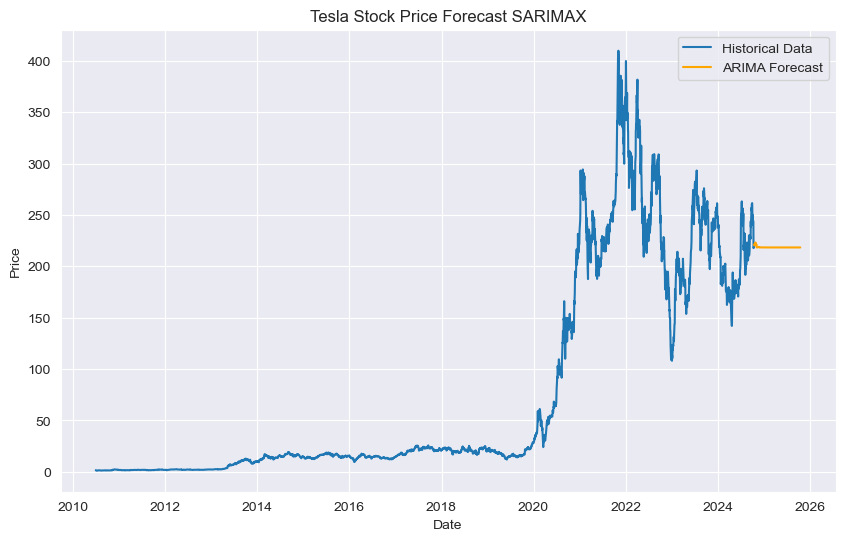

In [38]:


df_arima = data[['Close']].copy()

df_arima.index = pd.to_datetime(df_arima.index).tz_localize(None)

model = SARIMAX(df_arima['Close'], order=(2,1,2), seasonal_order=(2,0,0,12)) 
model_fit = model.fit()


future = pd.date_range(start=df_arima.index.max(), periods=365, freq='D')

forecast = model_fit.forecast(steps=365)

forecast_df = pd.DataFrame({'Date': future, 'Forecast': forecast})

plt.figure(figsize=(10,6))
plt.plot(df_arima.index, df_arima['Close'], label='Historical Data')
plt.plot(forecast_df['Date'], forecast_df['Forecast'], label='ARIMA Forecast', color='orange')

plt.title("Tesla Stock Price Forecast SARIMAX")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.show()


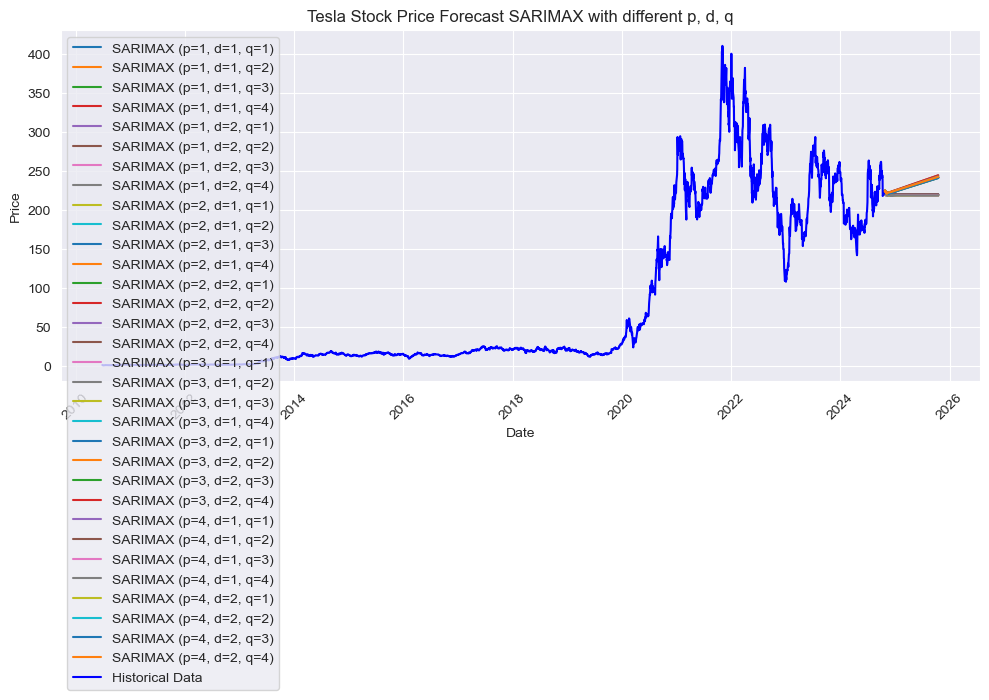

In [39]:
df_arima = data[['Close']].copy()
df_arima.index = pd.to_datetime(df_arima.index).tz_localize(None)

p_values = range(1, 5)
d_values = range(1, 3)
q_values = range(1, 5)

future = pd.date_range(start=df_arima.index.max(), periods=365, freq='D')

plt.figure(figsize=(10, 6))

for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                model = SARIMAX(df_arima['Close'], order=(p, d, q), seasonal_order=(2, 0, 0, 12))
                model_fit = model.fit(disp=False)

                forecast = model_fit.forecast(steps=365)
                plt.plot(future, forecast, label=f'SARIMAX (p={p}, d={d}, q={q})')

            except:
                pass

plt.plot(df_arima.index, df_arima['Close'], label='Historical Data', color='blue')

plt.title("Tesla Stock Price Forecast SARIMAX with different p, d, q")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


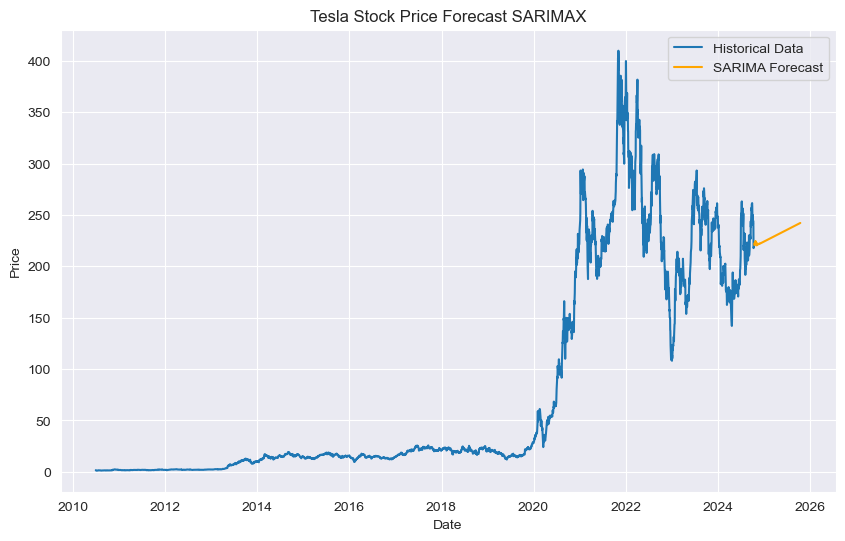

In [40]:


df_arima = data[['Close']].copy()

df_arima.index = pd.to_datetime(df_arima.index).tz_localize(None)

model = SARIMAX(df_arima['Close'], order=(3,2,2), seasonal_order=(2,0,0,12)) 
model_fit = model.fit()


future = pd.date_range(start=df_arima.index.max(), periods=365, freq='D')

forecast = model_fit.forecast(steps=365)

forecast_df = pd.DataFrame({'Date': future, 'Forecast': forecast})

plt.figure(figsize=(10,6))
plt.plot(df_arima.index, df_arima['Close'], label='Historical Data')
plt.plot(forecast_df['Date'], forecast_df['Forecast'], label='SARIMA Forecast', color='orange')

plt.title("Tesla Stock Price Forecast SARIMAX")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.show()


## Like ARIMA, auto test was not good

## prophet

In [41]:
df = pd.read_csv('TESLA_data_for_30_years.csv', parse_dates=True)
df.index.freq = 'MS'
df

Date        Open        High         Low  \
0     2010-06-29 00:00:00-04:00    1.266667    1.666667    1.169333   
1     2010-06-30 00:00:00-04:00    1.719333    2.028000    1.553333   
2     2010-07-01 00:00:00-04:00    1.666667    1.728000    1.351333   
3     2010-07-02 00:00:00-04:00    1.533333    1.540000    1.247333   
4     2010-07-06 00:00:00-04:00    1.333333    1.333333    1.055333   
...                         ...         ...         ...         ...   
3597  2024-10-14 00:00:00-04:00  220.130005  221.910004  213.740005   
3598  2024-10-15 00:00:00-04:00  220.009995  224.259995  217.119995   
3599  2024-10-16 00:00:00-04:00  221.399994  222.820007  218.929993   
3600  2024-10-17 00:00:00-04:00  221.589996  222.080002  217.899994   
3601  2024-10-18 00:00:00-04:00  220.710007  222.279999  219.229996   

           Close     Volume  Dividends  Stock Splits  
0       1.592667  281494500        0.0           0.0  
1       1.588667  257806500        0.0           0.0  
2       1.464000  123282000        0.0           0.0  
3       1.280000   77097000        0.0           0.0  
4       1.074000  103003500        0.0           0.0  
...          ...        ...        ...           ...  
3597  219.160004   86291900        0.0           0.0  
3598  219.570007   62988800        0.0           0.0  
3599  221.330002   49632800        0.0           0.0  
3600  220.889999   50791800        0.0           0.0  
3601  220.699997   49526800        0.0           0.0  

[3602 rows x 8 columns]

In [42]:
df = df.drop(columns=['Dividends', 'Stock Splits','Open','High','Low','Volume'])


In [43]:
df.columns = ['ds', 'y']
df['ds'] = pd.to_datetime(df['ds'])
df.head()

ds         y
0  2010-06-29 00:00:00-04:00  1.592667
1  2010-06-30 00:00:00-04:00  1.588667
2  2010-07-01 00:00:00-04:00  1.464000
3  2010-07-02 00:00:00-04:00  1.280000
4  2010-07-06 00:00:00-04:00  1.074000

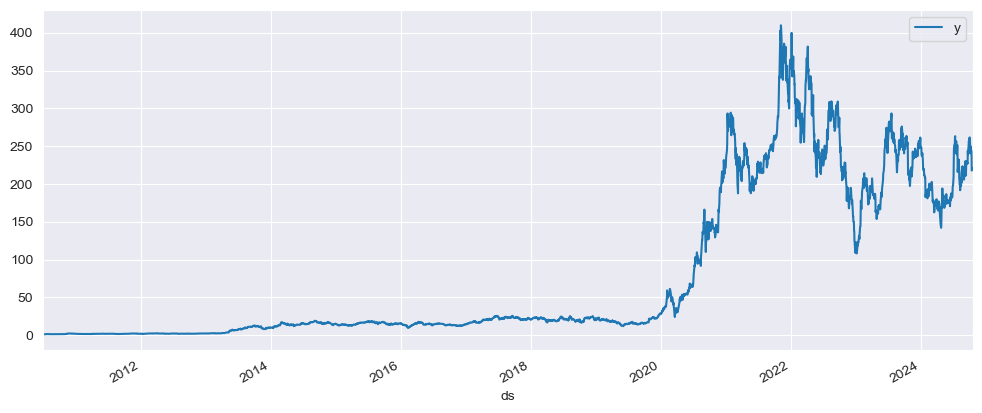

In [44]:
pd.plotting.register_matplotlib_converters()
df.plot(x='ds',y='y',figsize=(12,5)).autoscale(axis='x', tight=True);

In [45]:
train, test = df.iloc[:3560], df.iloc[3560:]

16:31:25 - cmdstanpy - INFO - Chain [1] start processing
16:31:28 - cmdstanpy - INFO - Chain [1] done processing


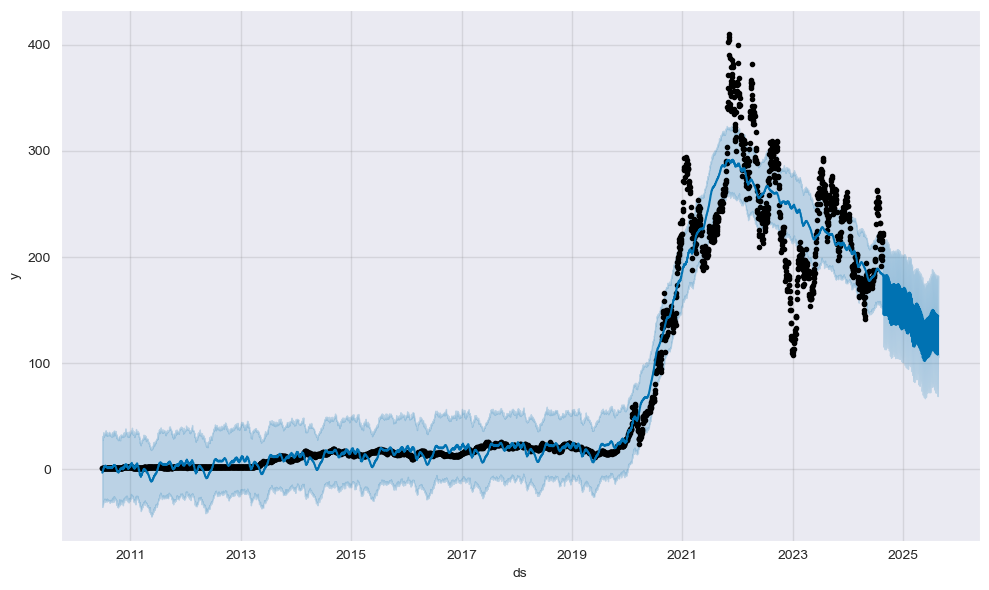

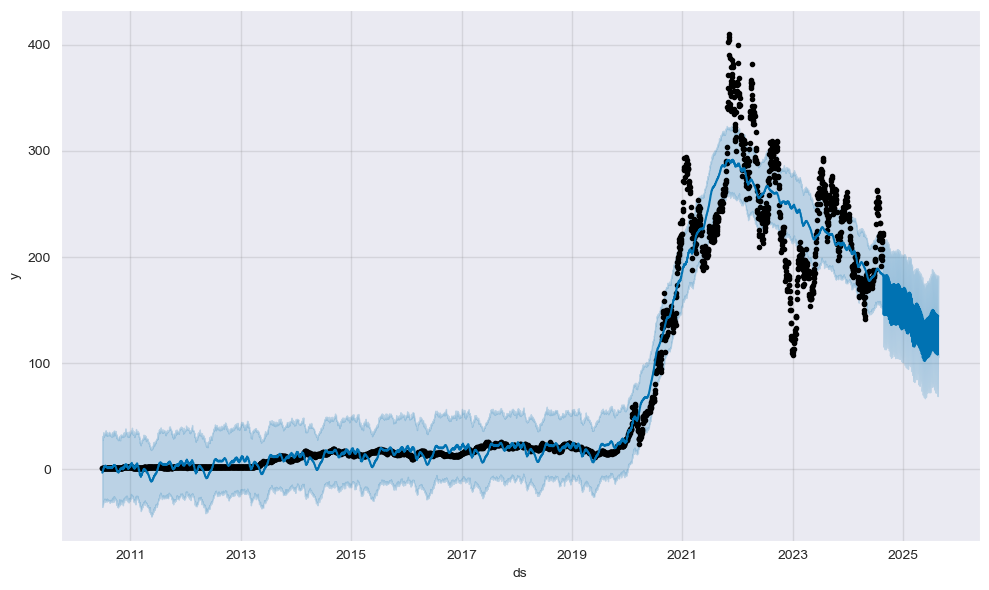

In [46]:
from prophet import Prophet

train['ds'] = pd.to_datetime(train['ds'], utc=True).dt.tz_localize(None)

m = Prophet().fit(train)

future = m.make_future_dataframe(periods=365, freq='D')

forecast = m.predict(future)

m.plot(forecast)


In [47]:
forecast.tail()

ds       trend  yhat_lower  yhat_upper  trend_lower  \
3920 2025-08-16 04:00:00  131.976780   69.005948  144.799813   114.886259   
3921 2025-08-17 04:00:00  131.870074   79.320980  151.570586   114.722849   
3922 2025-08-18 04:00:00  131.763368  109.504646  180.918413   114.454265   
3923 2025-08-19 04:00:00  131.656662  105.366591  182.310563   114.098079   
3924 2025-08-20 04:00:00  131.549957  108.405753  181.627305   113.741892   

      trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
3920   148.131938      -24.051643            -24.051643            -24.051643   
3921   148.083693      -17.886797            -17.886797            -17.886797   
3922   148.035449       13.073762             13.073762             13.073762   
3923   147.987205       12.792757             12.792757             12.792757   
3924   147.939235       12.793286             12.793286             12.793286   

         weekly  weekly_lower  weekly_upper    yearly  yearly_lower  \
3920 -27.163488    -27.163488    -27.163488  3.111844      3.111844   
3921 -20.987453    -20.987453    -20.987453  3.100656      3.100656   
3922   9.991240      9.991240      9.991240  3.082522      3.082522   
3923   9.734618      9.734618      9.734618  3.058139      3.058139   
3924   9.764569      9.764569      9.764569  3.028717      3.028717   

      yearly_upper  multiplicative_terms  multiplicative_terms_lower  \
3920      3.111844                   0.0                         0.0   
3921      3.100656                   0.0                         0.0   
3922      3.082522                   0.0                         0.0   
3923      3.058139                   0.0                         0.0   
3924      3.028717                   0.0                         0.0   

      multiplicative_terms_upper        yhat  
3920                         0.0  107.925136  
3921                         0.0  113.983277  
3922                         0.0  144.837130  
3923                         0.0  144.449419  
3924                         0.0  144.343243

In [48]:
test.tail()

ds           y
3597  2024-10-14 00:00:00-04:00  219.160004
3598  2024-10-15 00:00:00-04:00  219.570007
3599  2024-10-16 00:00:00-04:00  221.330002
3600  2024-10-17 00:00:00-04:00  220.889999
3601  2024-10-18 00:00:00-04:00  220.699997

In [49]:
test.head()

ds           y
3560  2024-08-21 00:00:00-04:00  223.270004
3561  2024-08-22 00:00:00-04:00  210.660004
3562  2024-08-23 00:00:00-04:00  220.320007
3563  2024-08-26 00:00:00-04:00  213.210007
3564  2024-08-27 00:00:00-04:00  209.210007

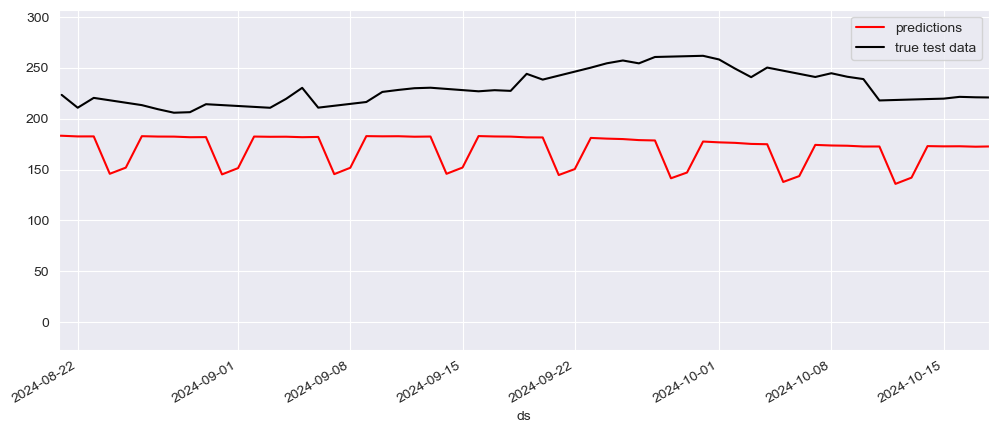

In [50]:
ax = forecast.plot(x='ds', y='yhat', label='predictions',legend=True, figsize=(12,5),color='red')
test.plot(x='ds', y='y', label='true test data', legend=True, ax=ax, xlim=('2024-08-21','2024-10-18'),color='black');

In [51]:
test['y']


3560    223.270004
3561    210.660004
3562    220.320007
3563    213.210007
3564    209.210007
3565    205.750000
3566    206.279999
3567    214.110001
3568    210.600006
3569    219.410004
3570    230.169998
3571    210.729996
3572    216.270004
3573    226.169998
3574    228.130005
3575    229.809998
3576    230.289993
3577    226.779999
3578    227.869995
3579    227.199997
3580    243.919998
3581    238.250000
3582    250.000000
3583    254.270004
3584    257.019989
3585    254.220001
3586    260.459991
3587    261.630005
3588    258.019989
3589    249.020004
3590    240.660004
3591    250.080002
3592    240.830002
3593    244.500000
3594    241.050003
3595    238.770004
3596    217.800003
3597    219.160004
3598    219.570007
3599    221.330002
3600    220.889999
3601    220.699997
Name: y, dtype: float64

In [52]:
predictions = forecast.iloc[3560:3602]['yhat']
predictions


3560    183.142891
3561    182.483852
3562    182.512948
3563    145.800740
3564    151.849596
3565    182.711167
3566    182.350130
3567    182.290777
3568    181.700301
3569    181.814904
3570    145.203475
3571    151.365972
3572    182.350958
3573    182.119425
3574    182.191486
3575    181.729786
3576    181.965745
3577    145.463389
3578    151.717886
3579    182.773242
3580    182.586279
3581    182.673478
3582    182.194520
3583    182.378650
3584    145.788603
3585    151.919215
3586    182.815158
3587    182.434944
3588    182.297745
3589    181.566893
3590    181.476177
3591    144.593658
3592    150.420162
3593    181.006866
3594    180.319135
3595    179.883166
3596    178.869300
3597    178.518127
3598    141.404122
3599    147.033952
3600    177.463900
3601    176.663553
Name: yhat, dtype: float64

In [53]:
from statsmodels.tools.eval_measures import rmse
rmse(predictions,test['y'])

62.80380160162236

In [54]:
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric

In [55]:

initial = 5 * 365
initial = str(initial) + ' days'

period = 5 * 365
period = str(period) + ' days'

horizon = 365
horizon = str(horizon) + ' days'



In [56]:
df_cv = cross_validation(m, initial=initial, period=period, horizon=horizon)

  0%|          | 0/2 [00:00<?, ?it/s]

16:31:33 - cmdstanpy - INFO - Chain [1] start processing
16:31:35 - cmdstanpy - INFO - Chain [1] done processing
16:31:36 - cmdstanpy - INFO - Chain [1] start processing
16:31:38 - cmdstanpy - INFO - Chain [1] done processing


In [57]:
performance_metrics(df_cv)


horizon         mse       rmse        mae      mape     mdape     smape  \
0    36 days  251.853154  15.869882  11.654273  0.155493  0.134227  0.143720   
1    37 days  253.273409  15.914566  11.806134  0.160951  0.136921  0.148073   
2    38 days  256.563775  16.017608  12.029398  0.160734  0.136921  0.147956   
3    39 days  262.270456  16.194766  12.333231  0.160823  0.136921  0.148163   
4    40 days  261.986808  16.186007  12.302084  0.164004  0.140194  0.151045   
..       ...         ...        ...        ...       ...       ...       ...   
317 361 days  306.526510  17.507899  15.445246  0.398078  0.361335  0.303449   
318 362 days  307.691709  17.541143  15.498104  0.402923  0.361335  0.306122   
319 363 days  308.863216  17.574505  15.550833  0.407791  0.361335  0.308792   
320 364 days  300.729634  17.341558  15.304151  0.412659  0.361335  0.310813   
321 365 days  288.690987  16.990909  14.993994  0.416949  0.361335  0.312403   

     coverage  
0        0.42  
1        0.42  
2        0.43  
3        0.44  
4        0.42  
..        ...  
317      0.50  
318      0.50  
319      0.50  
320      0.50  
321      0.50  

[322 rows x 8 columns]

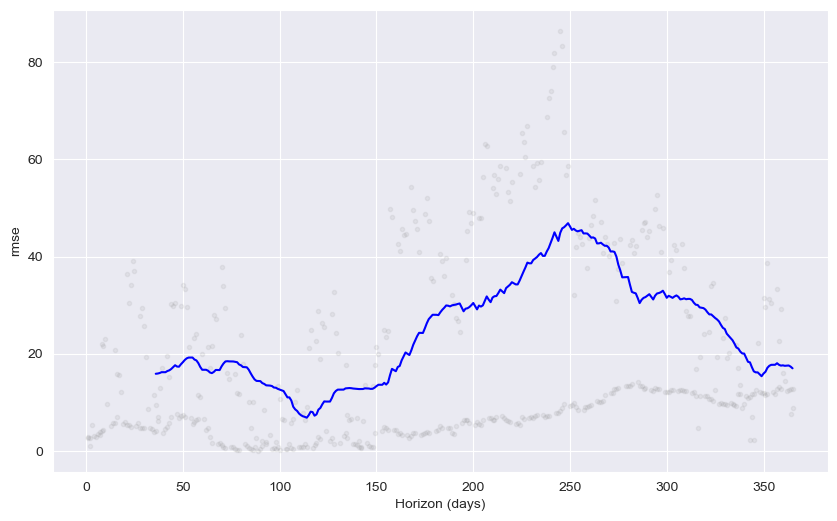

In [58]:
plot_cross_validation_metric(df_cv, metric='rmse');

16:52:05 - cmdstanpy - INFO - Chain [1] start processing
16:52:05 - cmdstanpy - INFO - Chain [1] done processing


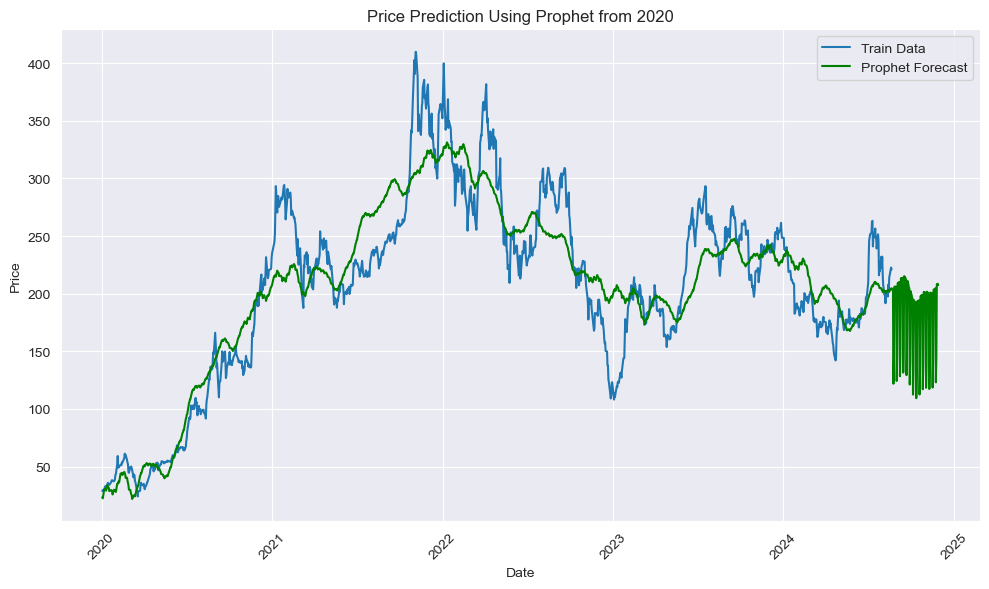

In [68]:
train_filtered = train[train['ds'] >= '2020-01-01'].copy()

train_filtered['ds'] = pd.to_datetime(train_filtered['ds']).dt.tz_localize(None)

m = Prophet().fit(train_filtered)

future = m.make_future_dataframe(periods=100, freq='D')

forecast = m.predict(future)

predictions = forecast[['ds', 'yhat']].copy()

plt.figure(figsize=(10, 6))
plt.plot(train_filtered['ds'], train_filtered['y'], label='Train Data')
plt.plot(predictions['ds'], predictions['yhat'], label='Prophet Forecast', color='green')
plt.title('Price Prediction Using Prophet from 2020')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Its seems like history have a strong impact on prophet, more than on the other algo's